In [25]:
pip install pytrends


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [26]:
import pandas as pd
data = pd.read_csv('trends_covid_symptoms_test_simulated.csv')
data.head()

,date,covid symptoms,covid test
0,2020-01-05,57.450712,95.978027
1,2020-01-12,47.926035,53.634941
2,2020-01-19,59.715328,71.070984
3,2020-01-26,72.845448,82.385465
4,2020-02-02,46.487699,53.001612


In [27]:
data.describe

<bound method NDFrame.describe of            date  covid symptoms  covid test
0    2020-01-05       57.450712   95.978027
1    2020-01-12       47.926035   53.634941
2    2020-01-19       59.715328   71.070984
3    2020-01-26       72.845448   82.385465
4    2020-02-02       46.487699   53.001612
..          ...             ...         ...
204  2023-12-03       29.334959   42.111728
205  2023-12-10       35.932624   39.255765
206  2023-12-17       57.725529   50.240664
207  2023-12-24       57.706789   73.218309
208  2023-12-31       57.725715   58.882462

[209 rows x 3 columns]>

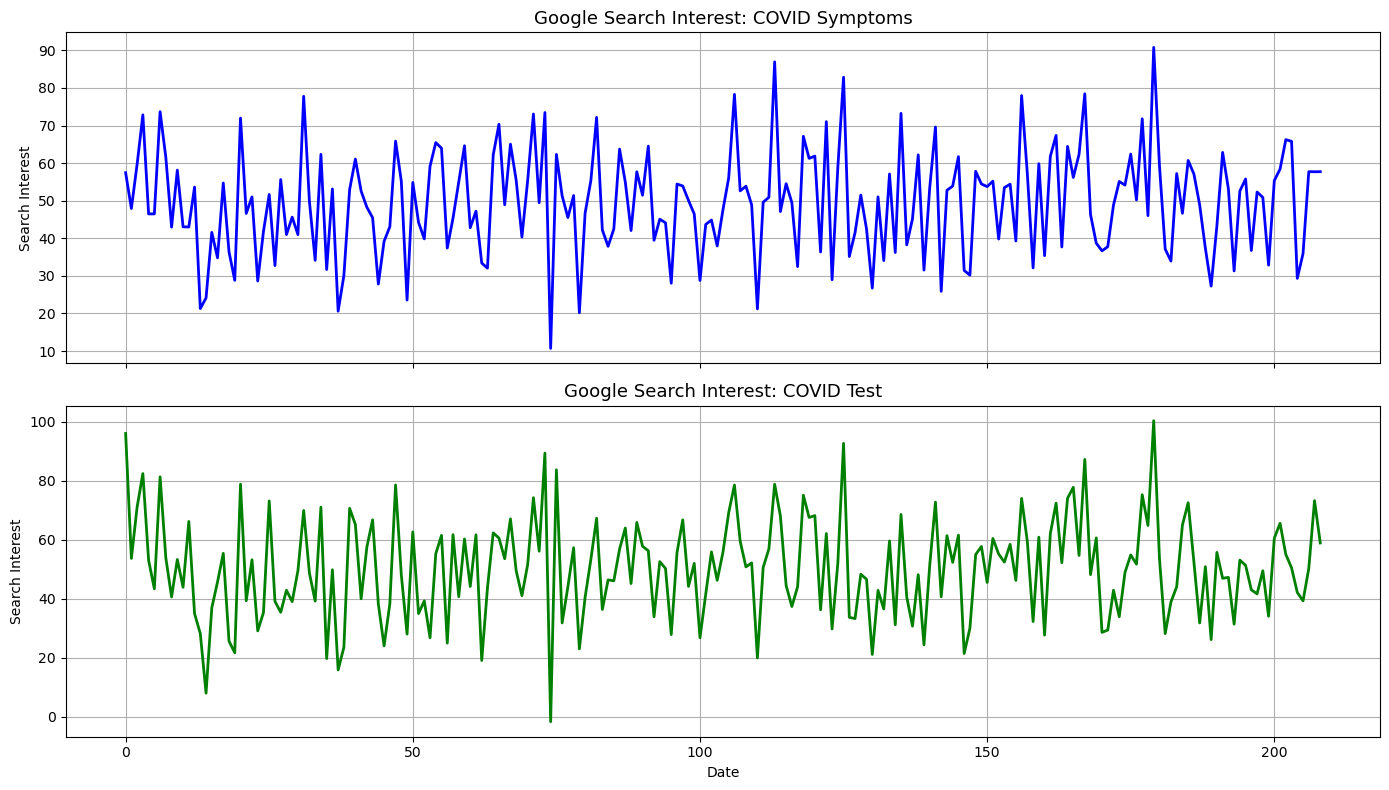

In [28]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# Plot 1: covid symptoms
axs[0].plot(data.index, data['covid symptoms'], color='blue', linewidth=2)
axs[0].set_title('Google Search Interest: COVID Symptoms', fontsize=13)
axs[0].set_ylabel('Search Interest')
axs[0].grid(True)

# Plot 2: covid test
axs[1].plot(data.index, data['covid test'], color='green', linewidth=2)
axs[1].set_title('Google Search Interest: COVID Test', fontsize=13)
axs[1].set_ylabel('Search Interest')
axs[1].set_xlabel('Date')
axs[1].grid(True)


plt.tight_layout()
plt.show()

##### 1. ADF Test for stationarity

In [29]:
from statsmodels.tsa.stattools import adfuller

In [30]:
def adf_test(series, name):
    result = adfuller(series)
    print(f"ADF Test for {name}:")
    print(f" Test Statistic : {result[0]:.4f}")
    print(f" p-value : {result[1]:.4f}")
    print(f" Critical Values:")
    for key, value in result[4].items():
        print(f" {key}: {value:.4f}")
    print(" =>", "Stationary" if result[1] < 0.05 else "Non-stationary", "\n")

In [31]:
adf_test(data['covid symptoms'], 'covid symptomps')
adf_test(data['covid test'], 'covid test')

ADF Test for covid symptomps:
 Test Statistic : -6.5816
 p-value : 0.0000
 Critical Values:
 1%: -3.4628
 5%: -2.8758
 10%: -2.5744
 => Stationary 

ADF Test for covid test:
 Test Statistic : -14.5191
 p-value : 0.0000
 Critical Values:
 1%: -3.4622
 5%: -2.8755
 10%: -2.5742
 => Stationary 



##### 2. Granger Causality Test

`covid symptoms`  →  `covid test`

To investigate whether the number of Google searches for "covid symptoms" helps predict future searches for "covid test", we applied the Granger causality test with lags up to 4.

 Hypothesis:
- **H₀ (null):** "covid symptoms" does NOT Granger-cause "covid test"
- **H₁ (alternative):** "covid symptoms" Granger-causes "covid test"

In [32]:
from statsmodels.tsa.stattools import grangercausalitytests

# Set the maximum number of lags to check for causality
max_lag = 5

# Granger causality test: Does 'covid symptoms' cause 'covid test'?
# Important: The first column is the dependent variable, the second is the explanatory one
print("Granger Causality Test: covid symptoms → covid test")
grangercausalitytests(data[['covid test', 'covid symptoms']], maxlag=max_lag, verbose=True)

# Granger causality test: Does 'covid test' cause 'covid symptoms'?
print("\nGranger Causality Test: covid test → covid symptoms")
grangercausalitytests(data[['covid symptoms', 'covid test']], maxlag=max_lag, verbose=True)

Granger Causality Test: covid symptoms → covid test

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2061  , p=0.6503  , df_denom=205, df_num=1
ssr based chi2 test:   chi2=0.2091  , p=0.6474  , df=1
likelihood ratio test: chi2=0.2090  , p=0.6475  , df=1
parameter F test:         F=0.2061  , p=0.6503  , df_denom=205, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.5357  , p=0.5861  , df_denom=202, df_num=2
ssr based chi2 test:   chi2=1.0980  , p=0.5775  , df=2
likelihood ratio test: chi2=1.0951  , p=0.5784  , df=2
parameter F test:         F=0.5357  , p=0.5861  , df_denom=202, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.2212  , p=0.8816  , df_denom=199, df_num=3
ssr based chi2 test:   chi2=0.6870  , p=0.8763  , df=3
likelihood ratio test: chi2=0.6858  , p=0.8765  , df=3
parameter F test:         F=0.2212  , p=0.8816  , df_denom=199, df_num=3

Granger Causality
number of lags (no zero

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


{1: ({'ssr_ftest': (1.7308343449701364, 0.18977381556037948, 205.0, 1),
   'ssr_chi2test': (1.7561636280672606, 0.18510375094706974, 1),
   'lrtest': (1.7487913678437508, 0.18602874642635148, 1),
   'params_ftest': (1.7308343449701271, 0.18977381556037948, 205.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (2.023767883582403, 0.13482747337163092, 202.0, 2),
   'ssr_chi2test': (4.147722296055024, 0.12569949913155168, 2),
   'lrtest': (4.106714590348247, 0.12830342721929214, 2),
   'params_ftest': (2.0237678835823454, 0.13482747337163908, 202.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (1.2175388151144464, 0.30446697991468746, 199.0, 3),
   'ssr_chi2test': (3.7811004409081796, 0.28609213323145005, 3),
   'lrtest': (3.746818520603483, 0.29013292412377656, 3),
   'params_ftest': (1.2175388151144226, 0.30446697991470223, 199.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 

Results:
All p-values for lag orders 1 to 4 were greater than 0.05:
- Lag 1: p = 0.6503
- Lag 2: p = 0.5861
- Lag 3: p = 0.8816
- Lag 4: p = 0.4046

Conclusion:
We fail to reject the null hypothesis. There is **no evidence** that "covid symptoms" Granger-causes "covid test" in this dataset.


`covid test` → `covid symptoms`

This test evaluates whether past values of "covid test" help predict "covid symptoms" using lag values from 1 to 4.

**Null Hypothesis (H₀):** "covid test" does NOT Granger-cause "covid symptoms"
**Alternative Hypothesis (H₁):** "covid test" Granger-causes "covid symptoms"

In [33]:
grangercausalitytests(data[['covid symptoms', 'covid test']], maxlag=4, verbose = True)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.7308  , p=0.1898  , df_denom=205, df_num=1
ssr based chi2 test:   chi2=1.7562  , p=0.1851  , df=1
likelihood ratio test: chi2=1.7488  , p=0.1860  , df=1
parameter F test:         F=1.7308  , p=0.1898  , df_denom=205, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.0238  , p=0.1348  , df_denom=202, df_num=2
ssr based chi2 test:   chi2=4.1477  , p=0.1257  , df=2
likelihood ratio test: chi2=4.1067  , p=0.1283  , df=2
parameter F test:         F=2.0238  , p=0.1348  , df_denom=202, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.2175  , p=0.3045  , df_denom=199, df_num=3
ssr based chi2 test:   chi2=3.7811  , p=0.2861  , df=3
likelihood ratio test: chi2=3.7468  , p=0.2901  , df=3
parameter F test:         F=1.2175  , p=0.3045  , df_denom=199, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.0280  , p=0.3939  

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


{1: ({'ssr_ftest': (1.7308343449701364, 0.18977381556037948, 205.0, 1),
   'ssr_chi2test': (1.7561636280672606, 0.18510375094706974, 1),
   'lrtest': (1.7487913678437508, 0.18602874642635148, 1),
   'params_ftest': (1.7308343449701271, 0.18977381556037948, 205.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (2.023767883582403, 0.13482747337163092, 202.0, 2),
   'ssr_chi2test': (4.147722296055024, 0.12569949913155168, 2),
   'lrtest': (4.106714590348247, 0.12830342721929214, 2),
   'params_ftest': (2.0237678835823454, 0.13482747337163908, 202.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (1.2175388151144464, 0.30446697991468746, 199.0, 3),
   'ssr_chi2test': (3.7811004409081796, 0.28609213323145005, 3),
   'lrtest': (3.746818520603483, 0.29013292412377656, 3),
   'params_ftest': (1.2175388151144226, 0.30446697991470223, 199.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 

**Result:**
All p-values > 0.05:
- Lag 1: p = 0.1898
- Lag 2: p = 0.1348
- Lag 3: p = 0.3045
- Lag 4: p = 0.3939

**Conclusion:**
We fail to reject the null hypothesis. There is no evidence of Granger causality from "covid test" to "covid symptoms".

3. VAR (Vector Autoregression) Model

In [34]:
from statsmodels.tsa.api import VAR

# Fit the VAR model to determine optimal lag length
model = VAR(data[['covid symptoms', 'covid test']])

# Evaluate lag order using AIC, BIC, FPE and HQIC
lag_results = model.select_order(maxlags=10)

# Print the criteria table
print(lag_results.summary())


 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       9.811*      9.845*  1.824e+04*      9.825*
1        9.830       9.929   1.857e+04       9.870
2        9.850       10.02   1.895e+04       9.917
3        9.882       10.11   1.958e+04       9.976
4        9.890       10.19   1.973e+04       10.01
5        9.904       10.27   2.001e+04       10.05
6        9.926       10.36   2.047e+04       10.10
7        9.962       10.46   2.121e+04       10.16
8        9.987       10.55   2.176e+04       10.21
9        10.02       10.65   2.250e+04       10.27
10       10.05       10.74   2.314e+04       10.33
--------------------------------------------------


Lag Order Selection

We applied a lag order selection procedure using the `VAR.select_order()` method with a maximum lag of 10. According to all information criteria (AIC, BIC, FPE, and HQIC), the optimal lag length was reported as **0**.

However, we have chosen to proceed with a **lag length of 1** for the following reasons:

- VAR(0) implies no temporal dependency, which is not realistic for time series with potential autocorrelation.
- Lag 1 allows the model to capture short-term dynamics between the variables.
- It is a common and parsimonious choice in applied time series literature, especially when the sample size is limited.

Thus, we fit a **VAR(1)** model to better capture potential interactions between the series over time.

In [35]:
from statsmodels.tsa.api import VAR

model = VAR(data[['covid symptoms', 'covid test']])
results = model.fit(maxlags=1)

results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 30, May, 2025
Time:                     17:45:15
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    9.90167
Nobs:                     208.000    HQIC:                   9.84432
Log likelihood:          -1604.04    FPE:                    18131.4
AIC:                      9.80540    Det(Omega_mle):         17619.5
--------------------------------------------------------------------
Results for equation covid symptoms
                       coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------------
const                    51.491050         3.576373           14.398           0.000
L1.covid symptoms        -0.169940         0.120040           -1.416           0.157
L1.covid test             0.128970 

Both equations in the VAR(1) model showed that the lagged values of "covid symptoms" and "covid test" were not statistically significant predictors of each other (p-values > 0.05).

This aligns with the Granger causality tests, suggesting that neither time series has strong predictive power over the other when considering only past values.

The residual correlation was moderately high (≈ 0.82), indicating simultaneous movement but not predictive causality.

4. Forecasting using VAR(1)

In [40]:
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace = True)

In [42]:
# Forecast 10 weeks ahead using VAR(1)
forecast_steps = 10
forecast = results.forecast(y=data[['covid symptoms', 'covid test']].values, steps=forecast_steps)

# Forecast dates (weekly)
last_date = data.index[-1]
forecast_index = pd.date_range(start=last_date + pd.Timedelta(weeks=1), periods=forecast_steps, freq='W')

# Convert forecast to DataFrame
forecast_df = pd.DataFrame(forecast,
index=forecast_index,
columns=['covid symptoms forecast', 'covid test forecast'])

# Display forecast
forecast_df.head()

,covid symptoms forecast,covid test forecast
2024-01-07,49.275191,49.869474
2024-01-14,49.548871,49.980363
2024-01-21,49.516663,49.967815
2024-01-28,49.520519,49.969317
2024-02-04,49.520057,49.969137


We generated a 10-week forecast for "covid symptoms" and "covid test" using the fitted VAR(1) model. The forecast begins from the first week of 2024 and shows a relatively stable pattern in both series.

This behavior is expected, as the VAR model coefficients were not strongly significant, and the Granger causality test suggested no strong dynamic relationship between the series.

Nevertheless, the model provides a valid short-term forecast, which could be useful for detecting subtle future changes in public interest related to COVID-19.